In [1]:
%load_ext autoreload
%autoreload 2

SEED = 99

import pymc as pm
import aesara
print("pymc version:", pm.__version__)
print("aesara version:", aesara.__version__)

pymc version: 4.1.3
aesara version: 2.7.7


# Introduction

The Generalized Gamma distribution is useful for survival analysis given its flexibility - it can parameterize the exponential, weibull, and gamma distributions (and more) when it's parameters take on certain values. This makes it great for 1) evaluating which distribution is a good fit for a dataset, and 2) fitting more flexible survival curves. 

In this blog post, I'm going to implement a probability distribution from scratch in Python, and implement a version that supports bayesian model fitting for PyMC as well. I'm not particularly an expert in any of these things so my goal here is to break down some theory and convert it to applied modeling in a way that others can understand.

__So if you're interested in starting to understand and apply more theory, hopefully this is for you!__


We'll cover 
 * statistics
 * some math
 * software engineering (including working with a code base)
 

Helpful Links
 * [Generalized Gamma distribution](https://en.wikipedia.org/wiki/Generalized_gamma_distribution)
 * [Stanford Survival Analysis Notes](https://web.stanford.edu/~lutian/coursepdf/unit1.pdf)
 * [PyMC notes](https://www.pymc.io/projects/docs/en/stable/contributing/developer_guide_implementing_distribution.html) for implementing a new distribution
 * [convoys](https://better.engineering/convoys/)
 
_Note that the Generalized Gamma distribution is actually supported in scipy, but this blogpost is going to pretend it isn't for the sake of learning_

<!-- 
## Light Background on Survival Analysis, Censored Data

We don't really need to understand survival analysis to get this job done, but it does help to see the usefulness.


Survival Analysis is the study of the time it takes for events to occur - for instance maybe we're interested in the time to failure of light bulbs -->

## The Generalized Gamma Distribution

There are two main sources I'm pulling from for this section - 
 * [Wikipedia](https://en.wikipedia.org/wiki/Generalized_gamma_distribution)
 * [Stanford Survival analysis course notes](https://web.stanford.edu/~lutian/coursepdf/unit1.pdf)
 
Distributions can be parameterized in many ways - even the two sources above choose to parameterize the Generalized Gamma distribution differently. 

I'm going to choose the $GG(\alpha, \rho, \lambda)$ parameterization from the Stanford course notes for a few reasons
 * They have good notes so its easy to follow along with
 * It aligns pretty well with the Exponential, Gamma, and Weibull distributions (and a few others I'm leaving out)
     * If $\alpha = \rho = 1, \text{ then } GG(1,1,\lambda) \sim \text{Exponential}(\lambda)$
     * If $\rho = 1, \text{ then } GG(\alpha,1,\lambda) \sim \text{Gamma}(\alpha, \lambda)$
     * If $\alpha = \rho, \text{ then } GG(\rho,\rho,\lambda) \sim \text{W}(\rho, \lambda)$
     
     
> _Note: the tilde notation in $X \sim Exponential(\lambda)$ just means that "X is distributed as an exponential distribution with parameter lambda"_

These special cases of the generalized gamma distribution are great, because we can also use them to check our work - we can compare our code to open source implementations of these other distributions to make sure our code is working

Let's get to work creating this distribution

## Implementing the Generalized Gamma in Python

It turns out, the Generalized Gamma distribution is actually already supported in `scipy` - but what if it wasn't? How would we implement the distribution ourselves?

Let's start simple (kind of). The __Probability Density Function (PDF)__ and __Cumulative Density Function (CDF)__ are below. These known functions are a great starting point since they're commonly used for fitting distributions and working with them in applied manners

The PDF is 

$$
f(x) = \frac{ p\lambda^{-1} (x/\lambda)^{\alpha - 1} e^{-(x/\lambda)^p}}
{\Gamma(\alpha/p)}
$$

And the CDF is

$$
F(x) = \frac{\gamma(\alpha / p, (x/\lambda)^{p})}
{\Gamma(\alpha/p)}
$$

where $\Gamma$ is the Gamma function and $\gamma$ is the lower incomplete gamma function. 

Its important to note that the lower incomplete gamma function in scipy is _regularized_, which in this case I found out means that it includes the the denominator term $\Gamma(\alpha/p)$ by default. So when we implement this in code with scipy, we dont need the denominator 

These 2 formulas are the exact same from the [Stanford Course Notes](https://web.stanford.edu/~lutian/coursepdf/unit1.pdf), the only difference is that I replaced $t$ with $x$, and I replaced $\lambda$ with $\frac{1}{\lambda}$ just to match how many other packages parameterize it. This change really doesnt impact anything besides the choice of input parameter value.

### The python class

So what features do we want for our distribution? 

As an MVP
 1. We want to be able to accept the 3 parameters as input
 2. We want to be able to know the probability density function at any point x
 3. We want to be able to know the cumulative density function at any point x 
 4. We want to be able to randomly sample data from the distribution
 
You might be asking, do we really need the PDF and CDF in the MVP? The answer is yes - the PDF comes in handy for fitting the distribution to a dataset, while the CDF comes in handy for interpreting the model, as well as random sampling - I'll get to that in a bit.

For now, I'll implement the PDF and CDF below (this code lives in `src/gen_gamma.py`)

```python
import numpy as np
import scipy.stats as stats
import scipy.special as sp
import numpy.typing as npt
from typing import Tuple, Optional, Union
# Type hint shortcut: tells us its a numpy array of float types
FloatArray = npt.NDArray[np.float64]

class GeneralizedGamma:
    
    def __init__(self, α: float, p: float, λ: float):
        '''A generalized gamma continuous random variable.
        '''        
        self.α = α
        self.p = p
        self.λ = λ
        
    def __repr__(self):
        '''Specifies what text a print statement should return'''
        return f'GG(α={round(self.α,2)}, p={round(self.p,2)}, λ={round(self.λ,2)})'
    
    def pdf(self, x: Union[float, FloatArray]) -> FloatArray:
        '''The probability density function evaluated at x
        '''        
        α, p, λ = self.α, self.p, self.λ
        
        return ((p/λ)*(x/λ)**(α-1)* np.exp(-1*(x/λ)**p)) / sp.gamma(α/p) 
    
    def cdf(self, x: Union[float, FloatArray]) -> FloatArray:
        '''The cumulative density function evaluated at x
        '''       
        α, p, λ = self.α, self.p, self.λ
        return sp.gammainc(α/p, (x/λ)**p) 
        
    
    def sample(self, size: int = 1) -> FloatArray:
        '''Samples from the distribution
        '''        
        raise NotImplementedError()
    
    def fit(self, data: FloatArray) -> Tuple[float, float, float]:
        '''Fits the distribution to a dataset and estimates parameters   
        '''
        raise NotImplementedError()

```



In [2]:
import numpy as np
import scipy.stats as stats
import scipy.special as sp
import numpy.typing as npt
from src.gen_gamma import GeneralizedGamma

gg = GeneralizedGamma(1,3,5)
print(gg)

GG(α=1, p=3, λ=5)


Ok so how do we know that we've gotten this right? How can we check our math? This is where unit tests come in! They're actually pretty easy in this case since we know that certain parameter conditions are equivalent to other distributions. (Note these tests live in the `tests/` folder

```python
import pytest
import unittest
import numpy as np 
import scipy.stats as stats
from src.gen_gamma import GeneralizedGamma


class TestGeneralizedGamma(unittest.TestCase):
    
    def test_exponential_pdf_matches(self):
        '''If  𝛼=𝜌=1, then 𝐺𝐺(1,1,𝜆)∼Exponential(𝜆)'''
        x = np.arange(1, 11)
        a = p = 1
        lambd = 5
        
        GG = GeneralizedGamma(a, p, lambd)
        expon_rv = stats.expon(scale=lambd)
        true_pdf = expon_rv.pdf(x)
        assert np.allclose(GG.pdf(x), true_pdf)
    
    def test_exponential_cdf_matches(self):
        '''If  𝛼=𝜌=1, then 𝐺𝐺(1,1,𝜆)∼Exponential(𝜆)'''
        x = np.arange(1, 11)
        a = p = 1
        lambd = 5
        
        GG = GeneralizedGamma(a, p, lambd)
        expon_rv = stats.expon(scale=lambd)
        true_cdf = expon_rv.cdf(x)
        assert np.allclose(GG.cdf(x), true_cdf)

    def test_gamma_pdf_matches(self):
        '''If  𝜌=1, then 𝐺𝐺(𝛼,1,𝜆)∼Gamma(𝛼,𝜆)'''
        x = np.arange(1, 11)
        a, p, lambd = 2,1,5
        
        GG = GeneralizedGamma(a, p, lambd)
        gamma_rv = stats.gamma(a, scale=lambd)
        true_pdf = gamma_rv.pdf(x)
        assert np.allclose(GG.pdf(x), true_pdf)

    def test_gamma_cdf_matches(self):
        '''If  𝜌=1, then 𝐺𝐺(𝛼,1,𝜆)∼Gamma(𝛼,𝜆)'''
        x = np.arange(1, 11)
        a, p, lambd = 2,1,5
        
        GG = GeneralizedGamma(a, p, lambd)
        gamma_rv = stats.gamma(a, scale=lambd)
        true_cdf = gamma_rv.cdf(x)
        assert np.allclose(GG.cdf(x), true_cdf)

    def test_weibull_pdf_matches(self):
        '''If  𝛼=𝜌, then 𝐺𝐺(𝜌,𝜌,𝜆)∼W(𝜌,𝜆)'''
        x = np.arange(1, 11)
        a = p = 10
        lambd = 5
        
        GG = GeneralizedGamma(a, p, lambd)
        weibull_rv = stats.weibull_min(p, scale=lambd)
        true_pdf = weibull_rv.pdf(x)
        assert np.allclose(GG.pdf(x), true_pdf)
        
    def test_weibull_cdf_matches(self):
        '''If  𝛼=𝜌, then 𝐺𝐺(𝜌,𝜌,𝜆)∼W(𝜌,𝜆)'''
        x = np.arange(1, 11)
        a = p = 10
        lambd = 5
        
        GG = GeneralizedGamma(a, p, lambd)
        weibull_rv = stats.weibull_min(p, scale=lambd)
        true_cdf = weibull_rv.cdf(x)
        assert np.allclose(GG.cdf(x), true_cdf)
```

In [3]:
# using an exclamation point is a hack to run command line from jupyter notebooks
!pytest tests

============================= test session starts ==============================
platform darwin -- Python 3.9.7, pytest-7.1.2, pluggy-1.0.0
rootdir: /Users/kylejcaron/Desktop/self_masters/teaching/case_studies/implementing_gen_gamma
plugins: anyio-3.5.0, cov-3.0.0
collected 14 items                                                             

tests/test_gen_gamma.py ..............                                   [100%]

============================== 14 passed in 9.98s ==============================


## Implementing a random sampling function

Great, we have the basic PDF and CDF functions implemented, but how do we go about randomly sampling from this distribution?

Well luckily there's something called __[Inverse Transform Sampling](https://en.wikipedia.org/wiki/Inverse_transform_sampling)__ we can utilize as an easy way to sample from any distribution. All we need is a random uniform sampler, and the Inverse Cumulative Density Function, $F^{-1}(q)$, also known as the quantile function. 

Basically, we uniformly randomly sample a quantile from 0 to 1 from a uniform distribution, and input that quantile into the Inverse CDF and the output is a randomly drawn sample.

So how can we implement this? We'll break it down into 2 steps: we'll define a quantile function by finding the inverse of the CDF, and we'll have another method to randomly sample from a uniform distribution and call the quantile function, returning our randomly sampled data.

Luckily wikipedia has a trick for calculating the quantile function of the Generalized Gamma (otherwise we might have to try calculating it ourselves):

$$
F^{-1}(q; \alpha, p, \lambda) = \alpha \cdot [G^{-1}(q)]^{1/p}
$$

where $G^{-1}(q)$ is the quantile function for a gamma distribution with $\alpha = \lambda / p, \beta = 1$

```python
class GeneralizedGamma:
    
    ...

    def sample(self, size: int = 1, seed: Optional[int] = None) -> FloatArray:
        '''Draws samples using the random inversion method
        '''
        if seed:
            np.random.seed(seed)
            
        q = np.random.uniform(size=size)
        return self.ppf(q) 
    
    def ppf(self, q: float) -> FloatArray:
        '''The percentile point function, or quantile function,
        of the Generalized Gamma
        '''
        α, p, λ = self.α, self.p, self.λ
        return λ * stats.gamma(a=α/p, scale=1).ppf(q) **(1/p)
```

We should be even more careful with unit tests here since we're calling on the scipy package which tends to have tricky parameter inputs, and we're drawing heavily from theory. So we'll add the following unit tests below

```python

class TestGeneralizedGamma(unittest.TestCase):
    
    ...
    
    def test_exponential_ppf_matches(self):
        '''If  𝛼=𝜌=1, then 𝐺𝐺(1,1,𝜆)∼Exponential(𝜆)'''
        q = np.arange(0, 1+0.001, 0.1)
        a = p = 1
        lambd = 5

        GG = GeneralizedGamma(a, p, lambd)
        expon_rv = stats.expon(scale=lambd)
        true_ppf = expon_rv.ppf(q)

        assert np.allclose(GG.ppf(q), true_ppf)
    
    def test_gamma_ppf_matches(self):
        '''If  𝜌=1, then 𝐺𝐺(𝛼,1,𝜆)∼Gamma(𝛼,𝜆)'''
        q = np.arange(0, 1+0.001, 0.1)
        a, p, lambd = 2,1,5

        GG = GeneralizedGamma(a, p, lambd)
        gamma_rv = stats.gamma(a, scale=lambd)
        true_ppf = gamma_rv.ppf(q)

        assert np.allclose(GG.ppf(q), true_ppf)
    
    def test_weibull_ppf_matches(self):
        '''If  𝛼=𝜌, then 𝐺𝐺(𝜌,𝜌,𝜆)∼W(𝜌,𝜆)'''
        q = np.arange(0, 1+0.001, 0.1)
        a = p = 10
        lambd = 5

        GG = GeneralizedGamma(a, p, lambd)
        weibull_rv = stats.weibull_min(p, scale=lambd)
        true_ppf = weibull_rv.ppf(q)

        assert np.allclose(GG.ppf(q), true_ppf)
```

The last thing we need to test for this section is that the random sampling works as intended - this is a little more tricky. Two ideas are:
 * We can run a Kolmogorov Smirnov test (KS-Tests) to compare randomly drawn samples against the CDF
 * We can run 2-sample KS-Tests to compare that randomly drawn samples from special cases of the Generalized Gamma match samples from other distributions
 
Its not always great to run hypothesis tests in unit testing, but we'll make `N` very, very large to avoid issues and not have to think about thinks like type I/type II errors from the hypothesis test.

```python
class TestGeneralizedGamma(unittest.TestCase):
    
    ...
    
    def test_exponential_sampling_matches(self):
        '''If  𝛼=𝜌=1, then 𝐺𝐺(1,1,𝜆)∼Exponential(𝜆)'''
        a = p = 1
        lambd = 5

        GG = GeneralizedGamma(a, p, lambd)
        expon_rv = stats.expon(scale=lambd)
        
        sample = expon_rv.rvs(self.N)
        _, pval = stats.ks_2samp(GG.sample(size=self.N), sample)
        assert pval > 0.05
        
    def test_gamma_sampling_matches(self):
        '''If  𝜌=1, then 𝐺𝐺(𝛼,1,𝜆)∼Gamma(𝛼,𝜆)'''
        q = np.arange(0, 1+0.001, 0.1)
        a, p, lambd = 2,1,5

        GG = GeneralizedGamma(a, p, lambd)
        gamma_rv = stats.gamma(a, scale=lambd)
        
        sample = gamma_rv.rvs(self.N)
        _, pval = stats.ks_2samp(GG.sample(size=self.N), sample)
        assert pval > 0.05

    def test_weibull_sampling_matches(self):
        '''If  𝛼=𝜌, then 𝐺𝐺(𝜌,𝜌,𝜆)∼W(𝜌,𝜆)'''
        a = p = 10
        lambd = 5

        GG = GeneralizedGamma(a, p, lambd)
        weibull_rv = stats.weibull_min(p, scale=lambd)
        
        sample = weibull_rv.rvs(self.N)
        _, pval = stats.ks_2samp(GG.sample(size=self.N), sample)
        assert pval > 0.05
    
    def test_sample(self):
        '''Compares the eCDF from randomly drawn samples to the cdf'''
        a, p, lambd = 2,3,5
        GG = GeneralizedGamma(a, p, lambd)
        draws = GG.sample(size=N)
        _, pval = stats.kstest(draws, GG.cdf)
        assert pval > 0.05
 ```

And lastly, to be extra careful, lets incorporate some visual testing. We'll 
 1. test randomly drawn samples against other distributions
 2. test the eCDF (empirical CDF) of a Generalized Gamma sample against the CDF we wrote for the Generalized Gamma distribution

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn")

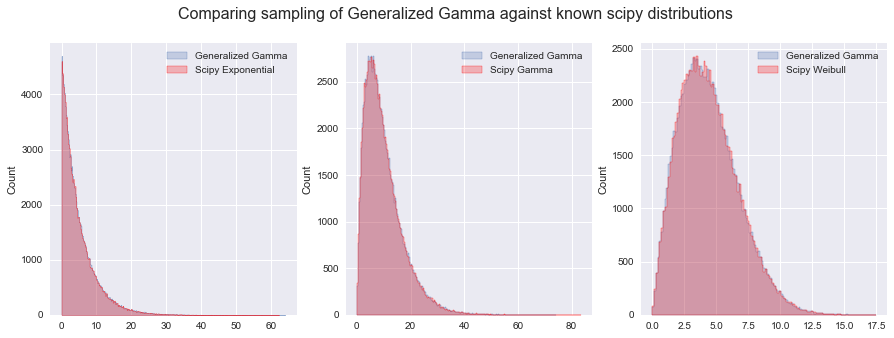

In [5]:
N = 100_000
test_combos = [
    [(1,1,5), stats.expon(scale=5), "Scipy Exponential"],
    [(2,1,5), stats.gamma(2, scale=5), "Scipy Gamma"],
    [(2,2,5), stats.weibull_min(2, scale=5), "Scipy Weibull"]
]

fig, ax = plt.subplots(1,3, figsize=(15,5))
for i, (params, dist, name) in enumerate(test_combos):
    gg = GeneralizedGamma(*params)
    sns.histplot(gg.sample(size=N), label="Generalized Gamma", ax=ax[i], alpha=0.25, element="step")
    sns.histplot(dist.rvs(size=N), label=name, color="r", ax=ax[i], alpha=0.25, element="step")
    ax[i].legend()
    
plt.suptitle("Comparing sampling of Generalized Gamma against known scipy distributions", fontsize=16);

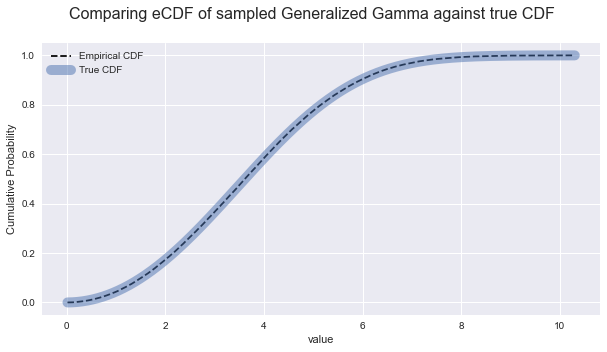

In [6]:
def ecdf(x):
    xs = np.sort(x)
    ys = np.arange(1, len(xs)+1)/float(len(xs))
    return xs, ys


fig, ax = plt.subplots(1,1, figsize=(10,5))

gg = GeneralizedGamma(2,3,5)
draws = gg.sample(size=N)
xs, ys = ecdf(draws)
ax.plot(xs, ys, label="Empirical CDF", color="k", ls="--")
ax.plot(xs, gg.cdf(xs), label="True CDF", color="C0", lw=10, alpha=0.5)
ax.legend()
ax.set_xlabel("value")
ax.set_ylabel("Cumulative Probability")
plt.suptitle("Comparing eCDF of sampled Generalized Gamma against true CDF", fontsize=16);

Great, everything matches visually as expected! We should feel pretty good about what we have so far. There's just one last piece missing - a method to fit the data

## Building a method for fitting to data

We're almost there - the last step is making sure we can fit the distribution to data and estimate parameters accurately.

To do this, we'll use the __Maximum Likelihood Method__ - basically we'll test a bunch of parameters and see which ones match the training dataset best. Implementing it is pretty easy nowadays as well thanks to scipy and out of the box optimization methods. 

We'll start by defining a likelihood function, then optimizing parameters to maximize the likelihood. Whats a likelihood function you ask? Well let's take a look at Bayes Theorem. 

$$
P(\theta | \text{data} ) = \frac{ P(\text{data} | \theta ) P(\theta) }{ P(\text{data}) }
$$

In this example
 * $\boldsymbol{ \theta }$ is a set of Generalized Gamma parameters
 * $ \boldsymbol{ P(\theta | \textbf{data} ) } $ is our posterior, the probability of some parameters being true given the data
 * $ \boldsymbol{P(\theta) }$ is a prior for what range of values $\boldsymbol{\theta}$ could take on, and how plausible those values are
 * $ \boldsymbol{P(\textbf{data}) }$ is the marginal probability of how likely the observed data is under all possible hypotheses (confusing, I know).
 * Finally, $ \boldsymbol{P(\textbf{data} | \theta )} $ is the probability of our data given a set of parameter values, $\boldsymbol{\theta}$. This is the __likelihood__, which is really just an unnormalized probability that maps how plausible some set of parameter values may be as a fit to the data. 
 
It turns out that we can use the probability density function as the likelihood function as long as we set the data as fixed and allow $\theta$ to vary - this lets us see which values of theta fit the data best.

Lets implement this. First we'll sample some fixed data, $y$


<AxesSubplot:ylabel='Count'>

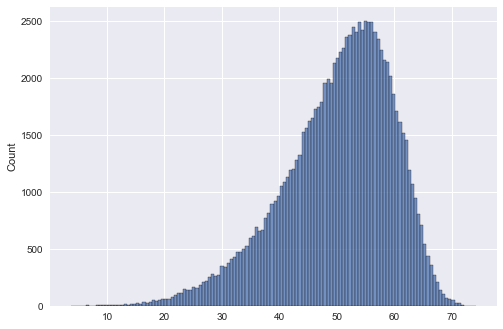

In [7]:
np.random.seed(SEED)
gg = GeneralizedGamma(5,11,60)
y = gg.sample(100_000)

# peek at the data
sns.histplot(y)

### Solving for the log PDF
Next we're going to need a log PDF function (I'll explain why in the next section)

We'll use some math to fit the log pdf. Quick math refresher, the log of multiplication is addition, the log of division is subtraction, $ln(e^x) = x$, and $ln(y^x) = x ln(y)$

$$
\text{pdf} = \frac{ k \lambda^{-1} (t/\lambda)^{\alpha-1} e^{-(t/\lambda)^k}}{\Gamma(\alpha/k)}\\
\text{log-pdf} = log(k \lambda^{-1} (t/\lambda)^{\alpha-1} e^{-(t/\lambda)^k}) - \text{log}\Gamma(\alpha/k))\\
\text{log-pdf} = log(k) - log(\lambda) + (\alpha-1) log(t/\lambda) -(t/\lambda)^k - \text{log}\Gamma(\alpha/k)
$$

We'll implement this in our GeneralizedGamma class

```python
class GeneralizedGamma:
    
    ...
    
    def logp(self, x):
        '''The log probability density function evaluated at x
        '''        
        α, p, λ = self.α, self.p, self.λ
        return (
            np.log(p) - np.log(λ)
            + (α-1)*np.log(x/λ)
            - (x/λ)**p
            - sp.loggamma(α/p)
```

### Defining a likelihood function

Next, we'll define a likelihood function. We're goig to actually instead define a negative log-likelihood function. There are a few reasons for this
 1. We choose the __log of the likelihood function__ to avoid [numerical stability issues](https://en.wikipedia.org/wiki/Log_probability) that arise from multiplying small fractions. Normally we'd find the likelihood of each data point given parameters and multiply them, but since the summation of logarithms is equivalent to multiplication, we can just take the log likelihoods and add them. __This is where our `logp()` function gets used!__

 2. We choose the __negative of the log-likelihood__ because scipy has a `minimize` function for optimization, but we're trying to maximize. So we just reverse the sign of our log-likelihood so that we're actually maximizing the log likelihood with the `minimze` function
 
 3. We'll also add in one more trick - we'll __solve for the logarithm of the parameters__ - the reason for this is to make sure the parameters are constrained to be positive. This makes it play nicely with the Generalized Gamma's PDF, which only supports positive parameter values. You can change the function to see for yourself what happens if we dont solve for the logarithm of parameters (spoiler: it doesnt consistently return good parameter estimates)

In [8]:
def negative_log_likelihood(log_theta, y):
    params = np.exp(log_theta)
    dist = GeneralizedGamma( *params )
    LL = dist.logp(y)
    return (-1 * LL).sum()

### Implementing maximum likelihood estimation

Finally, we'll call the minimize function below to run our maximum likelihood estimation method. Again, what this is doing under the hood is testing different parameter values for the Generalized Gamma distribution and returning the set of values that best fit our data

In [9]:
from scipy.optimize import minimize

In [10]:
mle_estimate = minimize(
    # our likelihood function
    negative_log_likelihood, 
    # initial test values for the optimization
    x0=np.log(np.array([1,1,10])), 
    # additional arguments for the likelihood function
    args=(y,), 
    # the optimization method to use
    method='L-BFGS-B')

# this solves for log(theta), so we use e^log(theta) = theta
theta_hat = np.exp( mle_estimate.x )
theta_hat

array([ 5.00214315, 10.99026722, 60.01254538])

Perfect, this identified the proper parameters with only a small margin of error! We can further see that below by sampling from the fitted distribution and comparing it to the actual data

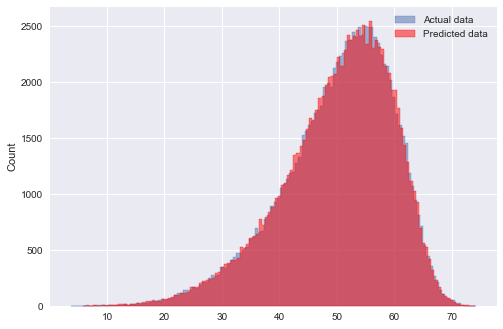

In [11]:
sampled_predictive_data = GeneralizedGamma(*np.exp(mle_estimate.x)).sample(100_000)

sns.histplot( y, alpha=0.5, element="step", label = "Actual data" )
sns.histplot( sampled_predictive_data , color="r", alpha=0.5, element="step", label = "Predicted data"  )
plt.legend()

Great, one last step, lets add this to our `GeneralizedGamma` class and add unit tests

```python
class GeneralizedGamma:

    ...
    
    def fit(y):
        
        def _negative_log_likelihood(log_theta, y):
            params = np.exp(log_theta)
            dist = GeneralizedGamma( *params )
            LL = dist.logp(y)
            return (-1 * LL).sum()

        mle_estimate = mle_estimate = minimize(
           _negative_log_likelihood, 
            x0=np.log(np.array([1,1,10])), 
            args=(y,), 
            method='L-BFGS-B')

        theta_hat = np.exp( mle_estimate.x )
        return GeneralizedGamma(*theta_hat)
```

There's a weird pattern to this function above - notice it doesn't include `self` in the method call. This is intentional - We don't want to fit the distribution if the distirbution already has parameter values inputted. 

I.e. this pattern is bad because we have to start by inputting some arbitrary parameter values even though we plan on tossing them away to find the actual fitted parameter values

```python
GG = GeneralizedGamma(1,2,5)
GG.fit(y)
print(GG)
```
> output: GG(5, 11, 60)

this pattern is much better and avoids confusion. To get this all we have to do is avoid including `self`

```python
GG = GeneralizedGamma.fit(y)
print(GG)
```
> output: GG(5, 11, 60)



In [12]:
GG = GeneralizedGamma.fit(y)
print(GG)

GG(α=5.0, p=10.99, λ=60.01)


Finally lets add some tests. This will actually be pretty easy - all we have to do is simulate some data based on true parameter values and make sure the fitting method gets close to the ground truth

```python

class TestGeneralizedGamma(unittest.TestCase):
    
    ...
    
    def test_fit(self):
        '''Makes sure that the fit method returns the expected parameter values'''
        theta = np.array([5,11,60])

        y = GeneralizedGamma(*theta).sample(self.N)
        GG = GeneralizedGamma.fit(y)
        theta_hat = np.array([GG.α, GG.p, GG.λ])
        assert np.allclose(theta, theta_hat, atol=1e-1)
```

Perfect, we now hit our first goal which is to implement a probability distribution from scratch in python!

# Implementing this distribution in PyMC 

I like to use bayesian methods and have a survival analysis project that utilizes a weibull distribution - it might benefit from trying out a Generalized Gamma distribution instead, so here I am, implementing this in PyMC.

Luckily there's [this fantastic guide](https://www.pymc.io/projects/docs/en/stable/contributing/developer_guide_implementing_distribution.html) on how to do it from the dev team at PyMC 

### Defining a `RandomVariable Op`

PyMC is basically built on top of another library, `Aesara`, and is sort of just an interface for it. So if we want to implement the Generalized Gamma distribution in PyMC, we need to implement it as a `RandomVariable` in Aesara. The dev team has made this a pretty easy process

In [13]:
from aesara.tensor.var import TensorVariable
from aesara.tensor.random.op import RandomVariable
from typing import List, Tuple
import scipy

import pymc as pm
from pymc.aesaraf import floatX, intX
from pymc.distributions.continuous import PositiveContinuous
from pymc.distributions.dist_math import check_parameters
import aesara.tensor as at


In [14]:
class GenGammaRV(RandomVariable):
    name: str = 'Generalized Gamma'
        
    # Provide the minimum number of (output) dimensions for this RV
    # (e.g. `0` for a scalar, `1` for a vector, etc.)
    ndim_supp: int = 0
        
    # Provide the number of (input) dimensions for each parameter of the RV
    # (e.g. if there's only one vector parameter, `[1]`; for two parameters,
    # one a matrix and the other a scalar, `[2, 0]`; etc.)
    ndims_params: List[int] = [0, 0, 0]

    # The NumPy/Aesara dtype for this RV (e.g. `"int32"`, `"int64"`).
    # The standard in the library is `"int64"` for discrete variables
    # and `"floatX"` for continuous variables
    dtype: str = "floatX"
        
    # A pretty text and LaTeX representation for the RV
    _print_name: Tuple[str, str] = ("blah", "\\operatorname{GG}")
    
    # If you want to add a custom signature and default values for the
    # parameters, do it like this. Otherwise this can be left out.
    def __call__(self, alpha=1.0, p=1.0, lambd=1.0, **kwargs) -> TensorVariable:
        return super().__call__(alpha, p, lambd, **kwargs)

    # This is the Python code that produces samples.  Its signature will always
    # start with a NumPy `RandomState` object, then the distribution
    # parameters, and, finally, the size.
    #
    # This is effectively the PyMC >=4.0 replacement for `Distribution.random`.
    @classmethod
    def rng_fn(
        cls,
        rng: np.random.RandomState,
        alpha: np.ndarray,
        p: np.ndarray,
        lambd: np.ndarray,
        size: Tuple[int, ...],
    ) -> np.ndarray:
        return GeneralizedGamma(alpha, p, lambd).sample(size=size, rng=rng)
    

We can check if this is working (stealing this from the docs again), by making sure the Op doesnt fail when trying to randomly draw samples

In [15]:
# Instantiate the actual `RandomVariable` `Op`...
gg = GenGammaRV()

# randomly draw samples
gg(5, 11, 60, size=10).eval()

array([36.21701669, 52.04327599, 59.86368142, 50.30412188, 53.94123575,
       57.31739321, 55.5905769 , 43.03770494, 57.19968883, 53.99353591])

### Implementing the PyMC distribution

We can now build the PyMC distribution by inheriting from the RandomVariable Op we defined above

This also requires us to implement logp and logcdf function. We already have most of them in our `GeneralizedGamma` class, but we need to define these operations in `Aesara`, so we need to re-write them.

$$
\text{CDF}(t) = \frac{ \gamma(\alpha/k, (\lambda t)^k) }{\Gamma(\alpha/k)}\\
\text{log-CDF}(t) = log(\gamma(\alpha/k, (\lambda t)^k) ) - \text{log}\Gamma(\alpha/k)
$$

Note that aesara's lower incomplete gamma function is also regularized, so we dont need the denominator term

$$
\text{log-CDF}(t) = log(\gamma(\alpha/k, (\lambda t)^k) ) 
$$

In [16]:
from pymc.aesaraf import floatX, intX
from pymc.distributions.continuous import PositiveContinuous
from pymc.distributions.dist_math import check_parameters
from pymc.distributions.shape_utils import rv_size_is_none

In [17]:
gengamma = GenGammaRV()

# Subclassing `PositiveContinuous` will dispatch a default `log` transformation
class GenGamma(PositiveContinuous):
    # This will be used by the metaclass `DistributionMeta` to dispatch the
    # class `logp` and `logcdf` methods to the `blah` `Op` defined in the last line of the code above.
    rv_op = gengamma
    
    # dist() is responsible for returning an instance of the rv_op.
    # We pass the standard parametrizations to super().dist
    @classmethod
    def dist(cls, alpha, p, lambd, **kwargs):
        alpha = at.as_tensor_variable(floatX(alpha))
        p = at.as_tensor_variable(floatX(p))
        lambd = at.as_tensor_variable(floatX(lambd))

        # The first value-only argument should be a list of the parameters that
        # the rv_op needs in order to be instantiated
        return super().dist([alpha, p, lambd], **kwargs)
    
    # moment returns a symbolic expression for the stable moment from which to start sampling
    # the variable, given the implicit `rv`, `size` and `param1` ... `paramN`.
    # This is typically a "representative" point such as the the mean or mode.
    def moment(rv, size, alpha, p, lambd):
        alpha, p, lambd = at.broadcast_arrays(alpha, p, lambd)
        moment = lambd * at.gamma((alpha+1)/p) / at.gamma(alpha/p)
        if not rv_size_is_none(size):
            moment = at.full(size, moment)
        return moment
    
    # Logp returns a symbolic expression for the elementwise log-pdf or log-pmf evaluation
    # of the variable given the `value` of the variable and the parameters `param1` ... `paramN`.
    def logp(value, alpha, p, lambd):
        logp_expression = (
            at.log(p) - at.log(lambd)
            + (alpha-1)*at.log(value/lambd)
            - (value/lambd)**p
            - at.math.gammaln(alpha/p)
        )

        # A switch is often used to enforce the distribution support domain
        bounded_logp_expression = at.switch(
            at.gt(value, 0),
            logp_expression,
            -np.inf,
        )

        # We use `check_parameters` for parameter validation. After the default expression,
        # multiple comma-separated symbolic conditions can be added.
        # Whenever a bound is invalidated, the returned expression raises an error
        # with the message defined in the optional `msg` keyword argument.
        return check_parameters(
            bounded_logp_expression,
            alpha > 0,
            p > 0,
            lambd > 0,
            msg="alpha > 0, p > 0, lambd > 0",
        )
    
    # logcdf works the same way as logp. For bounded variables, it is expected to return
    # `-inf` for values below the domain start and `0` for values above the domain end.
    def logcdf(value, alpha, p, lambd):
        logcdf_expression = at.log(at.gammainc(alpha/p, (value/lambd)**p)) 

        # A switch is often used to enforce the distribution support domain
        bounded_logcdf_expression = at.switch(
            at.gt(value, 0),
            logcdf_expression,
            -np.inf,
        )

        # We use `check_parameters` for parameter validation. After the default expression,
        # multiple comma-separated symbolic conditions can be added.
        # Whenever a bound is invalidated, the returned expression raises an error
        # with the message defined in the optional `msg` keyword argument.
        return check_parameters(
            bounded_logcdf_expression,
            alpha > 0,
            p > 0,
            lambd > 0,
            msg="alpha > 0, p > 0, lambd > 0",
        )
    
    

For a quick check that things are working (again, directly from the PyMC guide)

In [18]:
from pymc.distributions.distribution import moment

# pm.GeneralizedGamma = GeneralizedGamma
gg = GenGamma.dist(2,3,5)

# Test that the returned op is still working fine
gg.eval()

array(1.97941059)

In [19]:
# Test the moment method
moment(gg).eval(), GeneralizedGamma(2,3,5).expectation()

(array(3.69244056), 3.6924405581082413)

In [20]:
# Test the logp method
pm.logp(gg, [0.5, 1.5]).eval(), GeneralizedGamma(2,3,5).logp( np.array([0.5, 1.5]) )

(array([-3.11756099, -2.0449487 ]), array([-3.11756099, -2.0449487 ]))

In [21]:
# Test the logcdf method
pm.logcdf(gg, [0.5, 1.5]).eval(), np.log(GeneralizedGamma(2,3,5).cdf( np.array([0.5, 1.5]) ) )

(array([-4.50325531, -2.316398  ]), array([-4.50325531, -2.316398  ]))

Great, let's test out fitting a model with this!

### Model fitting - does it work?

<AxesSubplot:ylabel='Count'>

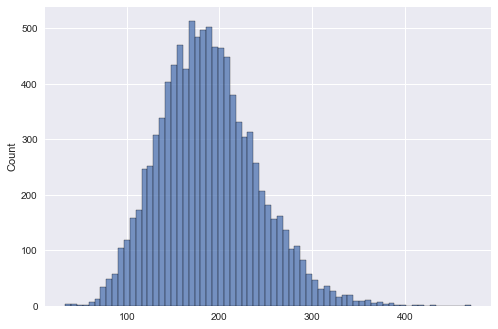

In [22]:
np.random.seed(SEED)
true_params = [8.5,1.5,60]
y = GeneralizedGamma(*true_params).sample(10_000)
sns.histplot(y)

In [23]:
with pm.Model() as m:
    
    # weakly informative priors for each parameter
    alpha = pm.Exponential("alpha", 1/5)
    p = pm.Lognormal("p", 0.45, 0.3)
    lambd = pm.Exponential("lambd", 1/60)
    
    # likelihood of the observed data
    obs = GenGamma("obs", alpha, p, lambd, observed=y)
    
    # fit
    idata = pm.sample(random_seed=SEED)
    idata.extend(pm.sample_prior_predictive())
    idata.extend(pm.sample_posterior_predictive(idata))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, p, lambd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 137 seconds.
The acceptance probability does not match the target. It is 0.8937, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8808, but should be close to 0.8. Try to increase the number of tuning steps.


It could definitely sample more efficiently - its likely sampling poorly because there are 3 parameters to solve for, each with wide priors. More informative priors could probably help speed this up.

But lets take a look at the fitted parameters

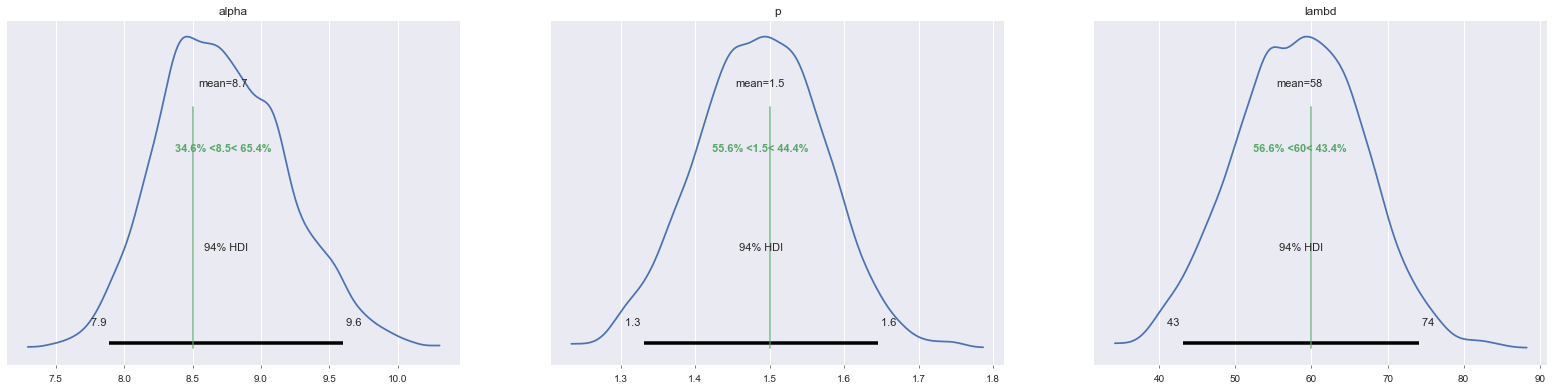

In [24]:
pm.plot_posterior(idata, ref_val=true_params);

Good news, the model works! We're able to correctly identify the true parameter estimates. We can also test this with larger N to be more sure (which I did on my own, but didn't include it hear because its slower).

# Adding this into PyMC

I want to make this supported by default in PyMC so I can start using it more regularly. I started digging around in the code-base on where to put my new functions so they're supported by default and it seems like I'll have to do the following:

 1. Find the right areas of their code base to insert my code
 2. Add my code to the right areas of their code base
 3. Implement unit tests to make sure everything works correctly as planned

__Here are some notes I made for where to insert my code and how to submit a PR:__

 * It looks like [pymc.distributions.continuous](https://github.com/pymc-devs/pymc/blob/main/pymc/distributions/continuous.py) is a good place for the PyMC distribution to live.

 * And a bit of a curve-ball, it looks like I'll have to implement the RV op withing aesara itself. For instance, look at the pattern for the [Uniform distribution](https://github.com/pymc-devs/pymc/blob/87c22c30d017ca74cef1329c9bcd3b06c38ac897/pymc/distributions/continuous.py#L256) - it [inherits](https://github.com/pymc-devs/pymc/blob/87c22c30d017ca74cef1329c9bcd3b06c38ac897/pymc/distributions/continuous.py#L299) an rv op [from aesara](https://github.com/pymc-devs/pymc/blob/87c22c30d017ca74cef1329c9bcd3b06c38ac897/pymc/distributions/continuous.py#L53). __This means I need 2 pull requests__

 * It turns out Aesara has a [ScipyRandomVariable](https://github.com/aesara-devs/aesara/blob/c19ac79965eb4b3b11f432fd46efc620aa28f72f/aesara/tensor/random/basic.py#L27) class that will let me use scipy for implementing the random variable. This is definitely helpful, since I want to keep their code base clean and follow their patterns, and given the Generalized Gamma distribution actually is supported in Scipy I might as well
 
 * Developer start guides for [Aesara](https://aesara.readthedocs.io/en/latest/dev_start_guide.html) and [PyMC](https://github.com/pymc-devs/pymc/blob/main/CONTRIBUTING.md) so I know the proper way to submit a PR for both projects
 
__Here are the 2 Pull Requests__:
 * [PyMC](https://github.com/pymc-devs/pymc/pull/5985)
 * [Aesara](https://github.com/aesara-devs/aesara/pull/1059)


# Putting this to use: An applied problem

Let's see if we can use this to improve upon weibull survival analysis. We'll simulate 2 groups
 * one group that is weibull distributed (remember when alpha=p in a Generalized Gamma Random Variable, it's equivalent to a Weibull Random Variable)
 * one group that Generalized Gamma Distributed
 
We'll fit a weibull model to both groups and see how it does, then test out our new model.

As a quick refresher to survival analysis, the `p` parameter of a Weibull distribution controls the acceleration of the hazard rate. Higher values of `p` mean that the hazard rate accelerates over time, making an event more and more likely.

The Generalized Gamma distribution, $GG(\alpha, p, \lambda)$ can almost be thought of as a $\text{Weibull}(p, \lambda)$ distribution, but with a lag before the acceleration starts, controlled by $\alpha$

### Simulating fake data

In [25]:
import pandas as pd
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from src.gen_gamma import GeneralizedGamma

In [26]:
np.random.seed(SEED)

true_paramsA = [2, 2, 60]
true_paramsB = [20, 2, 60]

# 2 groups that generate data
a = GeneralizedGamma(*true_paramsA)
b = GeneralizedGamma(*true_paramsB)
N = 100 # obs per group

# create a dataset of 2500 obs from each group
y_true = np.r_[
        a.sample(N, seed=SEED),
        b.sample(N, seed=SEED)
    ]

# randomly censor the dataset for survival analysis
cens_time = np.random.uniform(0, y_true.max(), size=N*2)

data = (
    pd.DataFrame({
    "group":[0]*N + [1]*N,
    "time": y_true})
    # adjust the dataset to censor observations
    ## indicates if an event hasnt occurred yet (cens=1)
    .assign(cens = lambda d: np.where(d.time <= cens_time, 0, 1) )
    ## indicates the latest time observed for each record
    .assign(time = lambda d: np.where(d.cens==1, cens_time, d.time) )
)

data.sample(5)

,group,time,cens
178,1,148.659190,1
3,0,10.724980,0
10,0,72.715854,0
48,0,9.538672,1
64,0,57.907152,1


### Original Approach: Weibull Survival Model

In [27]:
cens_ = np.where(data.cens==1, data.time, np.NaN)
COORDS = {"group": ["A","B"]}
group_ = data.group.values
y_ = data.time.values

with pm.Model(coords=COORDS) as m_weibull:
    
    # weakly informative priors for each parameter
    log_p = pm.Normal("log_p", 0.45, 0.3, dims="group")
    log_lambd = pm.Normal("log_lambd", 4.1, 0.4, dims="group")
    
    # helper vars
    p = pm.Deterministic("p", pm.math.exp(log_p), dims="group")
    lambd = pm.Deterministic("lambd", pm.math.exp(log_lambd), dims="group")

    # latent variable needed for censored fitting
    y_latent = pm.Weibull.dist( p[group_], lambd[group_] )
    
    # likelihood of the observed data
    obs = pm.Censored("obs", y_latent, lower=None, upper=cens_, observed=y_)
    
    # fit
    idata1 = pm.sample(init="adapt_diag", random_seed=SEED)
    idata1.extend(pm.sample_prior_predictive())
    idata1.extend(pm.sample_posterior_predictive(idata1))
    

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_p, log_lambd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


Taking a look at the posterior parameter estimates, the acceleration parameter is way off for group B. This also makes the value for lambda become biased

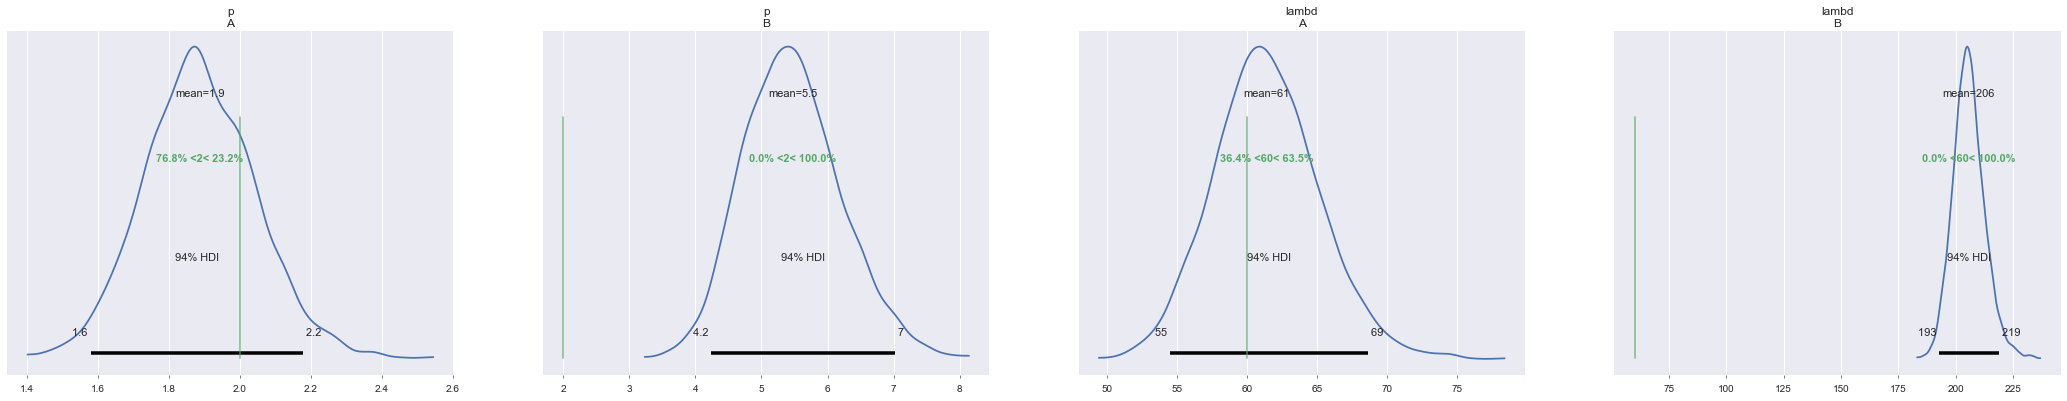

In [28]:
refs = list(np.c_[true_paramsA,true_paramsB][1:,:].ravel())
pm.plot_posterior(idata1, ref_val=refs, var_names=["p", "lambd"]);

/Users/kylejcaron/.pyenv/versions/3.9.7/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/kylejcaron/.pyenv/versions/3.9.7/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


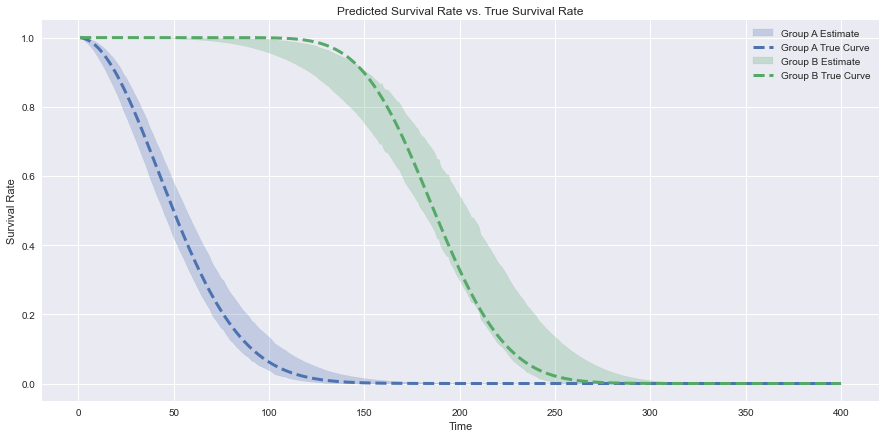

In [29]:
def plot_survival_curve(trace, true_a, true_b):
    post = trace.posterior
    
    # pull parameters
    p_hatA = post["p"].sel({"group":"A"}).values.ravel()[:,None]
    lambd_hatA = post["lambd"].sel({"group":"A"}).values.ravel()[:,None]
    ggA = GeneralizedGamma(p_hatA,p_hatA,lambd_hatA)

    p_hatB = post["p"].sel({"group":"B"}).values.ravel()[:,None]
    lambd_hatB = post["lambd"].sel({"group":"B"}).values.ravel()[:,None]
    ggB = GeneralizedGamma(p_hatB,p_hatB,lambd_hatB)

    t = np.arange(1,401)
    
    fig, ax = plt.subplots(1,1,figsize=(15,7))
    az.plot_hdi(t, 1-ggA.cdf(t), 
                ax=ax,
                color="C0", 
                smooth=False,
                fill_kwargs=dict(alpha=0.25,label="Group A Estimate"))
    ax.plot(t, 1-true_a.cdf(t), color="C0", ls="--", lw=3, label="Group A True Curve")

    az.plot_hdi(t, 1-ggB.cdf(t), color="C1", 
                ax=ax,
                smooth=False,
                fill_kwargs=dict(alpha=0.25,label="Group B Estimate"))
    ax.plot(t, 1-true_b.cdf(t), color="C1", ls="--", lw=3, label="Group B True Curve")

    ax.set_xlabel("Time")
    ax.set_ylabel("Survival Rate")
    ax.set_title("Predicted Survival Rate vs. True Survival Rate")
    ax.legend()
    
plot_survival_curve(idata1, a, b)

### Incorporating the new Generalized Gamma distribution

In [30]:
np.random.seed(SEED)

true_paramsA = [2, 2, 60]
true_paramsB = [20, 2, 60]

# 2 groups that generate data
a = GeneralizedGamma(*true_paramsA)
b = GeneralizedGamma(*true_paramsB)
N = 50 # obs per group

# create a dataset of 2500 obs from each group
y_true = np.r_[
        a.sample(N, seed=SEED),
        b.sample(N, seed=SEED)
    ]

# randomly censor the dataset for survival analysis
cens_time = np.random.uniform(0, y_true.max(), size=N*2)

data = (
    pd.DataFrame({
    "group":[0]*N + [1]*N,
    "time": y_true})
    # adjust the dataset to censor observations
    ## indicates if an event hasnt occurred yet (cens=1)
    .assign(cens = lambda d: np.where(d.time <= cens_time, 0, 1) )
    ## indicates the latest time observed for each record
    .assign(time = lambda d: np.where(d.cens==1, cens_time, d.time) )
)

data.sample(5)

,group,time,cens
8,0,129.660606,0
86,1,77.847286,1
25,0,30.029127,0
94,1,212.364493,0
87,1,190.509038,0


In [ ]:
cens_ = np.where(data.cens==1, data.time, np.NaN)
COORDS = {"group": ["A","B"]}
group_ = data.group.values
y_ = data.time.values

with pm.Model(coords=COORDS) as m_gen_gamma:
    
    # weakly informative priors for each parameter
    log_alpha = pm.Normal("log_alpha", 2, 0.75, dims="group")
    log_p = pm.Normal("log_p", 0.45, 0.3, dims="group")
    log_lambd = pm.Normal("log_lambd", 4.1, 0.4, dims="group")
    
    # helper vars
    alpha = pm.Deterministic("alpha", pm.math.exp(log_alpha), dims="group")
    p = pm.Deterministic("p", pm.math.exp(log_p), dims="group")
    lambd = pm.Deterministic("lambd", pm.math.exp(log_lambd), dims="group")

    # latent variable needed for censored fitting
    y_latent = GenGamma.dist( alpha[group_], p[group_], lambd[group_] )
    
    # likelihood of the observed data
    obs = pm.Censored("obs", y_latent, lower=None, upper=cens_, observed=y_)
    
    # fit
    idata2 = pm.sample(init="adapt_diag", random_seed=SEED)
    idata2.extend(pm.sample_prior_predictive())
    idata2.extend(pm.sample_posterior_predictive(idata2))
    

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_alpha, log_p, log_lambd]


/Users/kylejcaron/open_source/aesara/aesara/scalar/math.py:760: RuntimeWarning: invalid value encountered in double_scalars
  scipy.special.gammaincc(k, x) * (log_x - digamma_k)
/Users/kylejcaron/open_source/aesara/aesara/scalar/math.py:760: RuntimeWarning: invalid value encountered in double_scalars
  scipy.special.gammaincc(k, x) * (log_x - digamma_k)
